In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import os
import json
from sklearn.cluster import KMeans
from scipy import optimize

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go


In [2]:
import os

nouveau_chemin = '/Users/gabry/Desktop/VS/portfolio-optimization/data'

os.chdir(nouveau_chemin)

print("Nouveau chemin d'accès local :", os.getcwd())

Nouveau chemin d'accès local : /Users/gabry/Desktop/VS/portfolio-optimization/data


In [3]:
# Charger le fichier indices_prices.csv avec la colonne de date comme index
indices_price = pd.read_csv('indices_price.csv', index_col='Date', parse_dates=True)

# Charger le fichier stocks_price.csv avec la colonne de date comme index
stocks_price = pd.read_csv('stocks_price.csv', index_col='Date', parse_dates=True)

# Afficher les premières lignes pour vérifier
print(indices_price.head())
print(stocks_price.head())

                  BND        EEM          ^DJI        ^FCHI        ^FTSE  \
Date                                                                       
2022-12-02  71.258614  38.643650  34429.878906  6742.250000  7556.200195   
2022-12-05  70.696289  38.203850  33947.101562  6696.959961  7567.500000   
2022-12-06  70.928986  38.154984  33596.339844  6687.790039  7521.399902   
2022-12-07  71.549461  37.930199  33597.921875  6660.589844  7489.200195   
2022-12-08  71.345840  38.389542  33781.480469  6647.310059  7472.200195   

                  ^GDAXI        ^GSPC          ^HSI         ^IXIC  \
Date                                                                
2022-12-02  14529.389648  4071.699951  18675.349609  11461.500000   
2022-12-05  14447.610352  3998.840088  19518.289062  11239.940430   
2022-12-06  14343.190430  3941.260010  19441.179688  11014.889648   
2022-12-07  14261.190430  3933.919922  18814.820312  10958.549805   
2022-12-08  14264.559570  3963.510010  19450.230469  

In [4]:
#function to undertake Sharpe Ratio maximization subject to 
#basic constraints of the portfolio

#dependencies
import numpy as np
from scipy import optimize 

def MaximizeSharpeRatioOptmzn(MeanReturns, CovarReturns, RiskFreeRate, PortfolioSize):
    
    # define maximization of Sharpe Ratio using principle of duality
    def  f(x, MeanReturns, CovarReturns, RiskFreeRate, PortfolioSize):
        funcDenomr = np.sqrt(np.matmul(np.matmul(x, CovarReturns), x.T) )
        funcNumer = np.matmul(np.array(MeanReturns),x.T)-RiskFreeRate
        func = -(funcNumer / funcDenomr)
        return func

    #define equality constraint representing fully invested portfolio
    def constraintEq(x):
        A=np.ones(x.shape)
        b=1
        constraintVal = np.matmul(A,x.T)-b 
        return constraintVal
    
    
    #define bounds and other parameters
    xinit=np.repeat(0.33, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq})
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])
    
    #invoke minimize solver
    opt = optimize.minimize (f, x0 = xinit, args = (MeanReturns, CovarReturns,\
                             RiskFreeRate, PortfolioSize), method = 'SLSQP',  \
                             bounds = bnds, constraints = cons, tol = 10**-3)
    
    return opt

US treasury bonds (15/12/23)
6 Month Treasury Bill Rate (I:6MTBRNK) : 5.11%
1 Year Treasury Rate (I:1YTCMR) : 4,90%
2 Year Treasury Rate (I:2YTCMR) : 4,37%
5 Year Treasury Rate (I:5YTCMR) : 3,90%

In [28]:
indices_daily_return = indices_price.pct_change(1) # 1 for ONE DAY lookback
indices_monthly_return = indices_price.pct_change(21) # 21 for ONE MONTH lookback
indices_D_ret = indices_daily_return*100
indices_D_ret = indices_D_ret.iloc[1:]
indices_M_ret = indices_monthly_return*100
indices_M_ret = indices_M_ret.iloc[1:]

stocks_daily_return = stocks_price.pct_change(1) # 1 for ONE DAY lookback
stocks_monthly_return = stocks_price.pct_change(21) # 21 for ONE MONTH lookback
stocks_D_ret = stocks_daily_return*100
stocks_D_ret = stocks_D_ret.iloc[1:]
stocks_M_ret = stocks_monthly_return*100
stocks_M_ret = stocks_M_ret.iloc[1:]

In [29]:
#compute mean returns and variance covariance matrix of stocks returns
stocks_meanReturns = np.mean(stocks_D_ret, axis = 0)
stocks_covReturns = np.cov(stocks_D_ret, rowvar=False)
stocks_covReturns = pd.DataFrame(stocks_covReturns, columns=stocks_D_ret.columns, index=stocks_D_ret.columns)
#compute mean returns and variance covariance matrix of indices returns
indices_meanReturns = np.mean(indices_D_ret, axis = 0)
indices_covReturns = np.cov(indices_D_ret, rowvar=False)
indices_covReturns = pd.DataFrame(indices_covReturns, columns=indices_D_ret.columns, index=indices_D_ret.columns)
print('\nMean Returns:\n', stocks_meanReturns)
print('\nVariance-Covariance Matrix of Returns:\n', stocks_covReturns)


Mean Returns:
 AAPL    0.114721
ABBV   -0.029342
ABT     0.004096
ACN     0.065164
ADBE    0.253893
          ...   
UPS    -0.053006
V       0.073988
VZ      0.043181
WMT     0.014067
XOM     0.000428
Length: 107, dtype: float64

Variance-Covariance Matrix of Returns:
           AAPL      ABBV       ABT       ACN      ADBE       ADP      AMAT  \
AAPL  1.884350  0.025654  0.521781  1.035410  1.549472  0.788450  1.539117   
ABBV  0.025654  1.521024  0.375014  0.145271  0.080256  0.275102  0.063736   
ABT   0.521781  0.375014  1.663367  0.459404  0.580303  0.641449  0.497694   
ACN   1.035410  0.145271  0.459404  2.256916  1.587722  0.933813  1.613376   
ADBE  1.549472  0.080256  0.580303  1.587722  4.017926  1.005126  2.465669   
...        ...       ...       ...       ...       ...       ...       ...   
UPS   0.875576  0.267915  0.622436  1.059725  1.211615  0.908027  1.325896   
V     0.730167  0.212321  0.424951  0.674398  1.012779  0.466689  0.867011   
VZ    0.274838  0.140403  

In [10]:
#obtain maximal Sharpe Ratio for k-portfolio 1 of Dow stocks

#set portfolio size
portfolioSize = 107

#set risk free asset rate of return
Rf=4.9  # 1 Year Treasury Rate (I:1YTCMR) : 4,90%

annRiskFreeRate = Rf/100

#compute daily risk free rate in percentage
r0 = (np.power((1 + annRiskFreeRate),  (1.0 / 360.0)) - 1.0) * 100 
print('\nRisk free rate (daily %): ', end="")
print ("{0:.3f}".format(r0)) 

#initialization
xOptimal =[]
minRiskPoint = []
expPortfolioReturnPoint =[]
maxSharpeRatio = 0

#compute maximal Sharpe Ratio and optimal weights
result = MaximizeSharpeRatioOptmzn(stocks_meanReturns, stocks_covReturns, r0, portfolioSize)
xOptimal.append(result.x)

    
#compute risk returns and max Sharpe Ratio of the optimal portfolio   
xOptimalArray = np.array(xOptimal)
Risk = np.matmul((np.matmul(xOptimalArray,stocks_covReturns)), np.transpose(xOptimalArray))
expReturn = np.matmul(np.array(stocks_meanReturns),xOptimalArray.T)
annRisk =   np.sqrt(Risk*251) 
annRet = 251*np.array(expReturn) 
maxSharpeRatio = (annRet-Rf)/annRisk 

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)


#display results
print('Maximal Sharpe Ratio: ', maxSharpeRatio, '\nAnnualized Risk (%):  ', \
      annRisk, '\nAnnualized Expected Portfolio Return(%):  ', annRet)
print('\nOptimal weights (%):\n',  xOptimalArray.T*100 )


Risk free rate (daily %): 0.013
Maximal Sharpe Ratio:            0
0  3.485996 
Annualized Risk (%):             0
0  18.76285 
Annualized Expected Portfolio Return(%):   [70.307]

Optimal weights (%):
 [[ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 9.405]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [18.653]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 2.811]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [14.474]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [18.132]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 8.864]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 9.416]
 [15.76 ]
 [ 0.   ]
 [ 0.   ]
 [ 2.485]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0. 

In [15]:
xOptimalArray*100

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  9.405,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   , 18.653,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         2.811,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   , 14.474,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        18.132,  0.   ,  0.   ,  0.   ,  8.864,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  9.416, 15.76 ,  0.   ,  0.   ,  2.485,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ]])

In [27]:
# Supposons que vous voulez tracer la première ligne de xOptimalArray
ligne_a_tracer = np.array(xOptimalArray)[0]

# Créer un graphique en barres
fig = go.Figure(data=[go.Bar(
            x=list(range(len(ligne_a_tracer))), 
            y=ligne_a_tracer,
            hovertext=[f'Position: {i}' for i in range(len(ligne_a_tracer))],
            hoverinfo="text+y"
)])

# Mise à jour des étiquettes et du titre
fig.update_layout(title='Bar Plot des Poids Optimaux du Portefeuille',
                  xaxis_title='Indices des Actifs',
                  yaxis_title='Poids dans le Portefeuille')

# Afficher le graphique
fig.show()

### Constrained Portfolio Optimization

In [30]:
# Supposons que stocks_D_ret est votre DataFrame avec les rendements des actions
# et indices_D_ret est votre DataFrame avec les rendements des indices

# Extraire les rendements de l'indice ^IXIC
ixic_returns = indices_D_ret['^IXIC']

# Calculer la variance des rendements de l'indice ^IXIC
ixic_var = np.var(ixic_returns, ddof=1)

# Initialiser la liste pour stocker les bêtas
betas = []

# Calculer le bêta pour chaque stock
for stock in stocks_D_ret.columns:
    # Calculer la covariance entre les rendements du stock et ceux de l'indice ^IXIC
    covar = np.cov(stocks_D_ret[stock], ixic_returns, ddof=1)[0][1]
    
    # Calculer le bêta et l'ajouter à la liste
    beta = covar / ixic_var
    betas.append(beta)

# Créer une série Pandas pour les bêtas avec les noms des stocks comme index
betas_series = pd.Series(betas, index=stocks_D_ret.columns)

# Afficher les bêtas des actifs
print('Asset Betas:')
print(betas_series)


Asset Betas:
AAPL    0.937872
ABBV    0.009882
ABT     0.388923
ACN     0.863874
ADBE    1.296477
          ...   
UPS     0.752005
V       0.520814
VZ      0.224182
WMT     0.251460
XOM     0.204789
Length: 107, dtype: float64


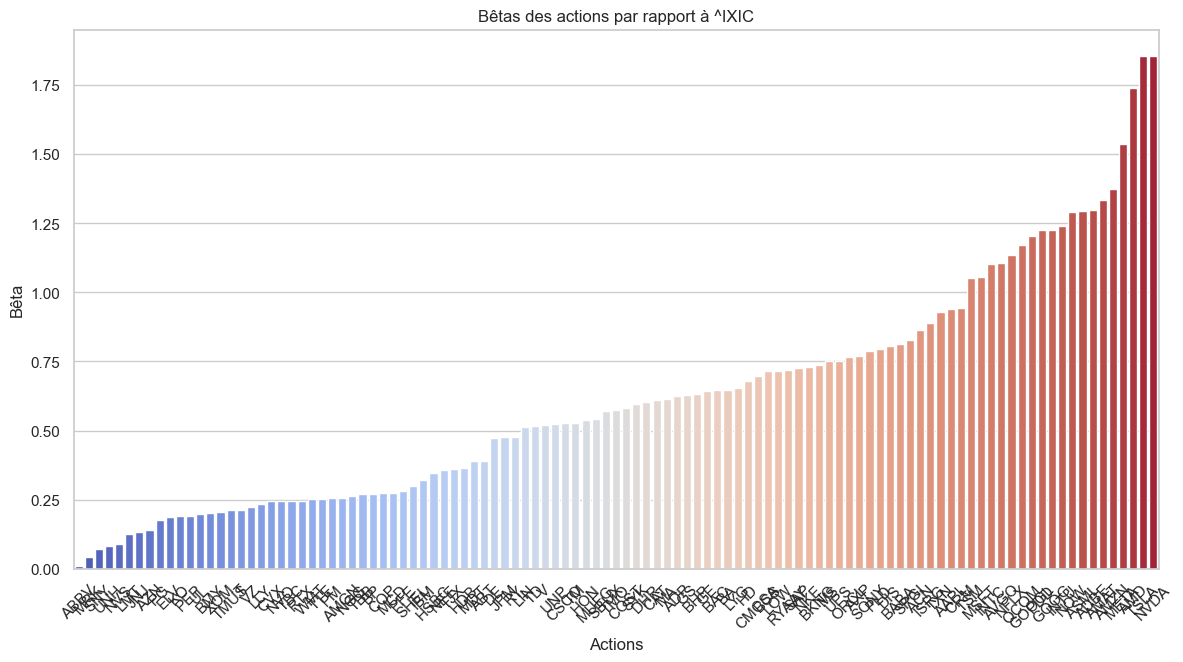

In [31]:
# Supposons que 'betas' est une liste ou une série Pandas contenant les bêtas calculés de vos actions.

# Importons d'abord les bibliothèques nécessaires.
import matplotlib.pyplot as plt
import seaborn as sns

# Supposons que 'betas_series' est la série Pandas contenant vos bêtas.
# Remplacez 'betas_series' par la série réelle contenant les bêtas de vos actions.
betas_series = pd.Series(betas_series.values, index = betas_series.index)  # Exemple de données

# Tri des bêtas pour améliorer la visualisation
betas_series_sorted = betas_series.sort_values()

# Configuration de Seaborn pour les graphiques plus esthétiques
sns.set(style="whitegrid")

# Création du graphique à barres
plt.figure(figsize=(14, 7))
ax = sns.barplot(x=betas_series_sorted.index, y=betas_series_sorted.values, palette="coolwarm")

# Ajout de titres et d'étiquettes
plt.title('Bêtas des actions par rapport à ^IXIC')
plt.xlabel('Actions')
plt.ylabel('Bêta')

# Rotation des étiquettes des axes x pour une meilleure lisibilité
plt.xticks(rotation=45)

# Afficher le graphique
plt.show()


In [39]:
#function to handle bi-criterion portfolio optimization with constraints

def BiCriterionFunctionOptmzn(MeanReturns, CovarReturns, RiskAversParam, PortfolioSize):
    
    def  f(x, MeanReturns, CovarReturns, RiskAversParam, PortfolioSize):
        PortfolioVariance = np.matmul(np.matmul(x, CovarReturns), x.T) 
        PortfolioExpReturn = np.matmul(np.array(MeanReturns),x.T)
        func = RiskAversParam * PortfolioVariance - (1-RiskAversParam)*PortfolioExpReturn
        return func
    
    def ConstraintEq(x):
        A=np.ones(x.shape)
        b=1
        constraintVal = np.matmul(A,x.T)-b 
        return constraintVal
    
    def ConstraintIneqUpBounds(x):
        A = np.where(betas_series > 1, 1, 0)
        bUpBounds =np.array([0.6,0.4]).T
        constraintValUpBounds = bUpBounds-np.matmul(A,x.T) 
        return constraintValUpBounds

    def ConstraintIneqLowBounds(x):
        A = np.where(betas_series > 1, 1, 0)
        bLowBounds =np.array([0.01, 0.01]).T
        constraintValLowBounds = np.matmul(A,x.T)-bLowBounds  
        return constraintValLowBounds
    
    xinit=np.repeat(0.01, PortfolioSize)
    cons = ({'type': 'eq', 'fun':ConstraintEq}, \
            {'type':'ineq', 'fun': ConstraintIneqUpBounds},\
            {'type':'ineq', 'fun': ConstraintIneqLowBounds})
            
    bnds = [(0, 0.1) if x > 1 else (0, 1) for x in betas_series]


    opt = optimize.minimize (f, x0 = xinit, args = ( MeanReturns, CovarReturns,\
                                                    RiskAversParam, PortfolioSize), \
                             method = 'SLSQP',  bounds = bnds, constraints = cons, \
                             tol = 10**-3)
    print(opt)
    
    return opt

In [40]:
#obtain optimal portfolios for the constrained portfolio optimization model
#Maximize returns and Minimize risk with fully invested, bound and 
#class constraints

#set portfolio size 
portfolioSize = 107

#initialization
xOptimal =[]
minRiskPoint = []
expPortfolioReturnPoint =[]

for points in range(0,60):
    riskAversParam = points/60.0
    result = BiCriterionFunctionOptmzn(stocks_meanReturns, stocks_covReturns, riskAversParam, \
                                       portfolioSize)
    xOptimal.append(result.x)

#compute annualized risk and return  of the optimal portfolios for trading days = 251  
xOptimalArray = np.array(xOptimal)
minRiskPoint = np.diagonal(np.matmul((np.matmul(xOptimalArray,stocks_covReturns)),\
                                     np.transpose(xOptimalArray)))
riskPoint =   np.sqrt(minRiskPoint*251) 
expPortfolioReturnPoint= np.matmul(xOptimalArray, stocks_meanReturns)
retPoint = 251*np.array(expPortfolioReturnPoint) 

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display optimal portfolio results
print("Optimal weights of the efficient set portfolios\n:", xOptimalArray)
print("\nAnnualized Risk and Return of the efficient set portfolios:\n",\
      np.c_[riskPoint, retPoint])

     fun: -0.2913783592101937
     jac: array([-0.115,  0.029, -0.004, -0.065, -0.254,  0.041, -0.168, -0.236,
       -0.003, -0.201, -0.078, -0.246, -0.06 ,  0.004, -0.114,  0.043,
        0.035, -0.019, -0.023, -0.18 ,  0.171, -0.038, -0.057, -0.089,
       -0.011, -0.085, -0.253, -0.011,  0.063,  0.057,  0.02 ,  0.013,
        0.017, -0.251, -0.131, -0.128,  0.012, -0.01 ,  0.032,  0.025,
       -0.13 , -0.056, -0.197, -0.159, -0.075,  0.031, -0.08 ,  0.021,
       -0.093, -0.197,  0.022,  0.001, -0.034, -0.065, -0.031, -0.025,
       -0.42 ,  0.007,  0.024, -0.171, -0.203,  0.119, -0.179, -0.055,
       -0.025, -0.227, -0.457, -0.212, -0.059, -0.158, -0.272,  0.023,
        0.199, -0.019, -0.029,  0.015, -0.044,  0.06 ,  0.013, -0.193,
       -0.159,  0.005, -0.076, -0.047, -0.028, -0.078, -0.097,  0.01 ,
       -0.017, -0.02 ,  0.022, -0.053, -0.12 ,  0.039, -0.009, -0.148,
       -0.103, -0.073,  0.03 ,  0.011, -0.023, -0.051,  0.053, -0.074,
       -0.043, -0.014, -0.   ])
 mess

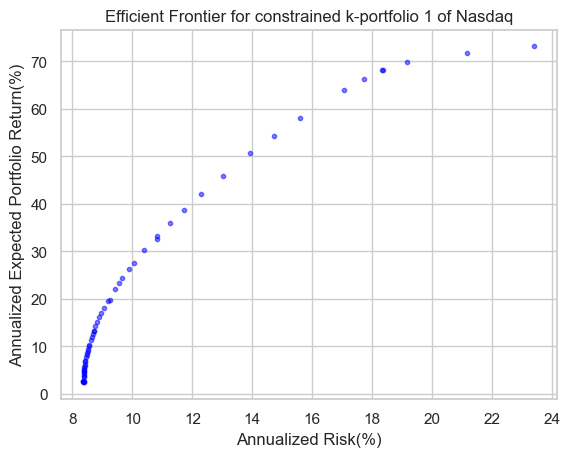

In [42]:
import matplotlib.pyplot as plt

#Graph Efficient Frontier for the constrained portfolio model
NoPoints = riskPoint.size

colours = "blue"
area = np.pi*3

plt.title('Efficient Frontier for constrained k-portfolio 1 of Nasdaq')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
plt.scatter(riskPoint, retPoint, s=area, c=colours, alpha =0.5)
plt.show()

In [44]:
np.c_[riskPoint, retPoint][0]

array([23.409, 73.136])

In [45]:
xOptimalArray[0]

array([0.   , 0.   , 0.   , 0.   , 0.079, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.02 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.312,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.289, 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.1  , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.1  , 0.   , 0.   , 0.   , 0.1  , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

In [46]:
# Supposons que vous voulez tracer la première ligne de xOptimalArray
ligne_a_tracer = np.array(xOptimalArray)[0]

# Créer un graphique en barres
fig = go.Figure(data=[go.Bar(
            x=list(range(len(ligne_a_tracer))), 
            y=ligne_a_tracer,
            hovertext=[f'Position: {i}' for i in range(len(ligne_a_tracer))],
            hoverinfo="text+y"
)])

# Mise à jour des étiquettes et du titre
fig.update_layout(title='Bar Plot des Poids Optimaux du Portefeuille',
                  xaxis_title='Indices des Actifs',
                  yaxis_title='Poids dans le Portefeuille')

# Afficher le graphique
fig.show()